# Text Classification of Textbooks
### Pierre Lardet

This code is presented as a python notebook, using python 3.11.2. I aim to develop a text classification model to classify textbook samples in 3 categories - Maths, Computer Science and History, using NLP concepts and ML methods.

I consulted various sources throughout this project. I used pages on [Monkey Learn](https://monkeylearn.com/) and Medium to perform reading around the subject, and then [this article](https://towardsdatascience.com/text-analysis-feature-engineering-with-nlp-502d6ea9225d) for much of the data cleaning feature engineering and [this article](https://medium.com/@bedigunjit/simple-guide-to-text-classification-nlp-using-svm-and-naive-bayes-with-python-421db3a72d34) for use of the sklearn's ML classifiers and evaluation. The [scikit-learn docs](https://scikit-learn.org/stable/) were also used frequently. Many other articles and forum posts were consulted, but all code copied is in the links above or mentioned explicitly in the code.

Versions of libraries used are listed below.  

- scikit-learn 1.2.2
- nltk 3.8.1
- pandas 2.0.0
- numpy 1.24.2
- seaborn 0.12.2
- matplotlib 3.7.1
- ipykernel 6.22.0


In [467]:
import glob
import pandas as pd
import re
import nltk
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, svm
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

nltk.download('stopwords')
nltk.download('wordnet')
np.random.seed(1000)

from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/pierrelardet/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/pierrelardet/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Data Cleaning

Before anything else, we need to be able to read in the text and convert it into a format which is easy to manipulate. I'm going to use a [Pandas dataframe](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html). I noticed that the Computer Science text files were nested in an extra directory so manually moved them to make the structure of text files consistent. Next, I read in all of the text files in an easily extensible manner, stored them in a 2d array labelled with their subject and created a new Pandas dataframe.

In [468]:
subjects = ['Computer_Science', 'History', 'Maths']
raw_texts = []

def read_subject_data(subject:str)->None:
    for dir in glob.glob(f'./data/{subject}/*.txt'):
        f = open(dir, 'r')
        text = f.read()
        raw_texts.append([subject, text])
        f.close()

for subject in subjects:
    read_subject_data(subject)

In [469]:
textbooks = pd.DataFrame(raw_texts, columns=['subject', 'text'])

textbooks = textbooks[textbooks['text'] != '']

print('-'*50)
print(f'Sample of the data: \n {textbooks.head()}')
print('-'*50)
print(f'Dimensions: {textbooks.shape}')
print('-'*50)
print(f'Counts of each subject: \n {textbooks.groupby("subject").count()}')
print('-'*50)



--------------------------------------------------
Sample of the data: 
             subject                                               text
0  Computer_Science  4.8 Exercises 275\n4.15 [IS) <§§4.2, 4.3> One ...
1  Computer_Science  4.5 Fallacies and Pitfalls 26.\nFirst we find ...
2  Computer_Science  518 Chapter 7 Large and Fast: Exploiting Memor...
3  Computer_Science  Computers\nReconstructing the\nin the\nAncient...
4  Computer_Science  230 Chapter 3 Arithmetic: for Computers\n3.9 [...
--------------------------------------------------
Dimensions: (1341, 2)
--------------------------------------------------
Counts of each subject: 
                   text
subject               
Computer_Science   637
History            490
Maths              214
--------------------------------------------------


Now we have a dataframe to work with. The text is currently very messy with lots of extra characters and spacing etc. In order to use the text as an input into a ML classification model, it needs to be much cleaner. The desired format will be a list of lower-case words in each sample which can later be converted to numeric values.

I replace new lines, remove all non-alphabetic characters, remove stopwords and perform lemmatization on each word. The only potentially problematic choice here is to remove numbers and symbols from the dataset. Dates in the historic text may be relevant and perhaps one might expect a greater number of digits in a maths textbook, but there are many exercise numbers and other other symbols in the text which I do not think will help the model distinguish between subjects. This is a point I could return to if the model is lacking significant features, but as it turns this does not become an issue and in fact there are more than enough features in the words alone. 

In [470]:
stopwords = nltk.corpus.stopwords.words('english')
lem = WordNetLemmatizer()
in_stopwords = lambda word: word not in stopwords

def clean_text(str:str) -> str:
    str = re.sub(r'\n', ' ', str) # Replace new lines and spaces
    str = re.sub(r'[^a-zA-Z]+', ' ', str) # Retain only alphabetic characters
    str = str.lower()

    lst_words = str.split(' ')

    lst_words = list(filter(in_stopwords, lst_words)) # Remove stopwords from nltk corpus
    lst_words = [lem.lemmatize(word) for word in lst_words] # Lemmatize all words

    return ' '.join(lst_words)

textbooks['text_clean'] = textbooks['text'].apply(clean_text)

print(textbooks['text_clean'].head())

0     exercise one user told three program exercise...
1     fallacy pitfall first find execution time two...
2     chapter large fast exploiting memory hierarch...
3    computer reconstructing ancient world real wor...
4     chapter arithmetic computer ioj bit address t...
Name: text_clean, dtype: object


### Exploration

We can investigate some simple properties of the data such as prevalence of each lable in the data and average length of sample.

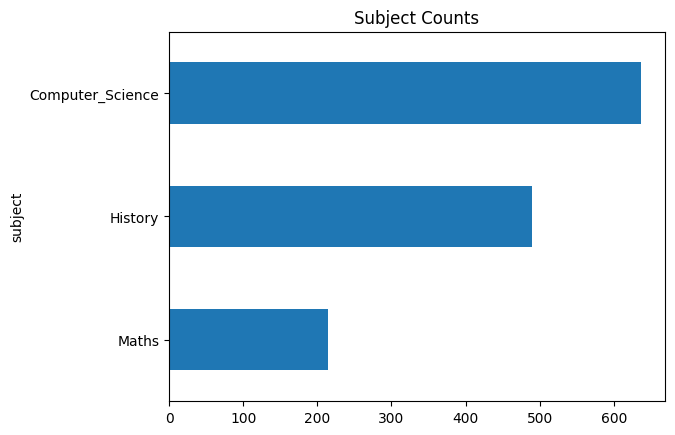

In [471]:
fig, ax = plt.subplots()
ax.set_title('Subject Counts')
textbooks['subject'].reset_index().groupby('subject').count().sort_values(by= 
       "index").plot(kind="barh", legend=False, 
        ax=ax)
plt.show()

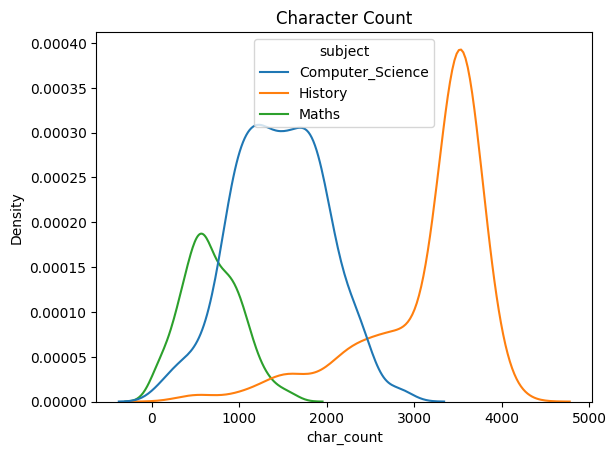

In [482]:
fig, ax = plt.subplots()
ax.set_title('Character Count')
textbooks['char_count'] = textbooks['text_clean'].apply(len)
sns.kdeplot(textbooks, x='char_count', hue='subject')
plt.show()


Clearly, History has longer samples in this data and Maths the shortest. However, there is lots of overlap so we continue with this fact borne in mind in case this could be used as a feature if the text is lacking in other meaninful features.

### Feature Engineering

We now have clean text and can engineer these into ML features. I'm going to use the Tfidf class from scikit-learn. I'm also going to split the data into training and test data start with 30% being reserved for testing. 

The reason for using Tfidf because I do not believe more complex context-based features are required in this case. One might imagine that 

In [473]:
train_x, test_x, train_y, test_y = model_selection.train_test_split(textbooks['text_clean'], textbooks['subject'], test_size=0.3, random_state=4)

encoder = LabelEncoder()
train_y = encoder.fit_transform(train_y)
test_y = encoder.transform(test_y)

Tfidf_vect = TfidfVectorizer()
tfidf_train_x = Tfidf_vect.fit_transform(train_x)
tfidf_test_x = Tfidf_vect.transform(test_x)

print(f'Number of features: {tfidf_train_x.shape[1]}')


Number of features: 22466


### ML Classification Model

Finally, we can bring in an ML classification model and train it on the data.

I am choosing to use a Support Vector Machine with a linear kernel. This model is known to perform well with smaller datasets where the number of features is large, as well as for text classification since these problems are normally linearly separable. The other advantage of linear SVM is that we can extract the coefficients of each feature and use these to explain how SVM is classifying inputs. I do this at the end

In [474]:
SVM = svm.SVC(C=1.0, kernel='linear', random_state=0).fit(tfidf_train_x, train_y)

### Evaluation

Below I have produced a number of different metrics for the model. Evaluation of the model depends upon its purpose. Are false positives or false negatives particularly important to avoid for any particular label? Since the data pertains to textbooks, I suspect that the simple metric of accuracy is a good measure of the model's effectiveness since I doubt misclassifying any particular class would have severe consequences. 

In [475]:
predictions = SVM.predict(tfidf_test_x)
print('-'*70)
print(classification_report(test_y, predictions, labels=range(0,len(encoder.classes_)), target_names=encoder.classes_))
print('-'*70)
print('Confusion Matrix: \n', confusion_matrix(test_y, predictions, labels=range(0,len(encoder.classes_))))
print('-'*70)
print('Precise overall accuracy: ', accuracy_score(test_y, predictions))

----------------------------------------------------------------------
                  precision    recall  f1-score   support

Computer_Science       1.00      0.99      0.99       192
         History       0.99      1.00      0.99       148
           Maths       1.00      1.00      1.00        63

        accuracy                           1.00       403
       macro avg       1.00      1.00      1.00       403
    weighted avg       1.00      1.00      1.00       403

----------------------------------------------------------------------
Confusion Matrix: 
 [[190   2   0]
 [  0 148   0]
 [  0   0  63]]
----------------------------------------------------------------------
Precise overall accuracy:  0.9950372208436724


From the confusion matrix we can see that the model only misclassified 2 of the Computer Science samples as History. This results in a very high accuracy for the model. This may be indicative of overfitting, especially since we have over 20000 features.

Given the results found later that the model performs well with fewer features, I do not think the model is overfitted. Instead, I believe that the data lends itself well to being classified, especially by an effective model like SVM. However, the data may be of a particular type of textbooks - maybe of a particular author with a particular vocabulary, or of a certain level or topic - which makes the model less generalisable. However there is no way for a model to learn words which are not in the data!

### Improvements

There are various ways the model might be improved - both in terms of its evaluation metrics including those above, or its efficiency and utility.

Firstly, hyperparameters of the SVM model could be adjusted further than I have here, with cross validation metrics used to algorithmically find the optimal set of parameters (although would require reserving some of the data for validation to avoid overfitting). This could include the kernel type, the regularisation parameter and others. However, in this case the model has reached very high accuracy already.

Other supervised classification methods like logistic regression or Naive Bayes might be investigated to see how effective they are, but it seems unlikely they will have improved accuracy given how well SVM performed above. However, were SVM to be less effective, it could be valuable to explore other models. This might also include deep learning methods, especially if there were more data available.

On the feature engineering side, we might be able reduce the number of features either to improve performace of the model, or more likely improve the efficiency of the code. This has not been an issue thus far as there is a manageable quantity of data such that the code does not take long at all to run, but if there were orders of magnitude more data, feature selection could become very useful, especially if cross validation is being used. This could be achieved using the SVM coefficients output or using a Chi^2 test, like in the code below. 

We could also include the character count feature found earlier as a feature. If the model were lacking significant features, this may be useful, but given its accuracy, it seems unlikely that the inclusion of the character count would improve the model.

In [479]:
selector = SelectKBest(chi2, k = 100)
selected_train_x = selector.fit_transform(tfidf_train_x, train_y)
selected_test_x = selector.transform(tfidf_test_x)

selected_svm = svm.SVC(C=1.0, kernel='linear', random_state=0).fit(selected_train_x, train_y)
selected_predictions = selected_svm.predict(selected_test_x)

print('-'*70)
print('Metric report with k=100 features:')
print('-'*70)
print(classification_report(test_y, selected_predictions, labels=range(0,len(encoder.classes_)), target_names=encoder.classes_))
print('-'*70)
print('Confusion matrix with k=100 features:')
print('-'*70)
print(confusion_matrix(test_y, selected_predictions, labels=range(0,len(encoder.classes_))))
print('-'*70)

----------------------------------------------------------------------
Metric report with k=100 features:
----------------------------------------------------------------------
                  precision    recall  f1-score   support

Computer_Science       0.97      0.98      0.97       192
         History       0.97      1.00      0.99       148
           Maths       1.00      0.90      0.95        63

        accuracy                           0.98       403
       macro avg       0.98      0.96      0.97       403
    weighted avg       0.98      0.98      0.97       403

----------------------------------------------------------------------
Confusion matrix with k=100 features:
----------------------------------------------------------------------
[[188   4   0]
 [  0 148   0]
 [  6   0  57]]
----------------------------------------------------------------------


As it turns out, we can achieve very high performance with an order of magnitude fewer features. Previously we had over 20000 features, but with just 100 features, we only misclassify 10 of the inputs. However, reducing the number of features so drastically may make the model less effective when consdering new samples using a different vocabulary as the model can take into account fewer words.

We can also investigate how changing the train/test split might affect the performance. If we can reduce the training size without significantly reducing performance of the model, we free up more data to be used in the test in the hopes that evaluation is more reliable and less likely to be overly optimstic/pessimistic.

In [477]:
split_train_x, split_test_x, split_train_y, split_test_y = model_selection.train_test_split(textbooks['text_clean'], textbooks['subject'], test_size=0.6, random_state=4)

encoder = LabelEncoder()
split_train_y = encoder.fit_transform(split_train_y)
split_test_y = encoder.transform(split_test_y)

split_Tfidf_vect = TfidfVectorizer()
split_tfidf_train_x = split_Tfidf_vect.fit_transform(split_train_x)
split_tfidf_test_x = split_Tfidf_vect.transform(split_test_x)

selector = SelectKBest(chi2, k = 1000)
split_train_x = selector.fit_transform(split_tfidf_train_x, split_train_y)
split_test_x = selector.transform(split_tfidf_test_x)

large_test_svm = svm.SVC(C=1.0, kernel='linear', random_state=0).fit(split_train_x, split_train_y)

print(f'Number of features: {split_train_x.shape[1]}')
split_predictions = large_test_svm.predict(split_test_x)
print('-'*70)
print('Metric report with k=100 features:')
print('-'*70)
print(classification_report(split_test_y, split_predictions, labels=range(0,len(encoder.classes_)), target_names=encoder.classes_))
print('-'*70)
print('Confusion matrix with k=100 features:')
print('-'*70)
print(confusion_matrix(split_test_y, split_predictions, labels=range(0,len(encoder.classes_))))
print('-'*70)



Number of features: 1000
----------------------------------------------------------------------
Metric report with k=100 features:
----------------------------------------------------------------------
                  precision    recall  f1-score   support

Computer_Science       0.99      0.99      0.99       373
         History       0.99      1.00      1.00       298
           Maths       1.00      0.99      0.99       134

        accuracy                           1.00       805
       macro avg       1.00      0.99      0.99       805
    weighted avg       1.00      1.00      1.00       805

----------------------------------------------------------------------
Confusion matrix with k=100 features:
----------------------------------------------------------------------
[[371   2   0]
 [  0 298   0]
 [  2   0 132]]
----------------------------------------------------------------------


I use k=1000 features and a 50/50 training/test split and the model only misclassifies 4 inputs, almost as good as the original model with all (> 20000) features and 30/70 split which misclassified 2 inputs. In fact, given the test size being roughly double, the accuracy is nearly the same between the models.

Clearly, the model does not need all of the data and all of the features to perform well on this kind of data. SVM is known to not require lots of data to perform well unlike deep-learning algorithms.

Notice that the number of features has reduced before selection since there are fewer samples in the training set. The potential vocabulary of the model is smaller. However, I select the k=1000 best featuress anyway, and as we saw with feature selection, this does not significantly reduce the accuracy of the model.

Lastly, to improve usability and maintainability of the model, we could use sklearn's [Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html), which might have been useful above. However, given the scope of this project and the fact I wanted to present my thoughts and discoveries as chronologically as possible, I have not used such a tool in this case. In a final model, it would make sense to pipeline the Tfidf vectorizer, feature selectoin, SVM and evluation into one process.

### Extensions

Firstly, we might extend the model to be able to handle other categories. There are a couple instances where I have hard-coded the subject names/encoded labels but these could be changed to all originate from 1 array. In the majority of cases, I written code that would work if the number of categories were increased. The main exception is for the 

Secondly, since the SVM kernel is linear, the coefficients for each feature can easily be extracted and the features with the greatest effect on the classifier's choice of class can be visualised. This data, and the plots generated, do a great deal of work to explain of the model. 

Sklearn's SVM implementation works by a series of binary classifications and generates a coefficient array for each possible combination of classes. Fortunately there are only 3 classes in this case, so I have mapped each coefficient array to its relevant binary classification decision and plotted the 20 words with the greatest effect on the outcome on either side of each combination.

Code for plotting was copied from https://aneesha.medium.com/visualising-top-features-in-linear-svm-with-scikit-learn-and-matplotlib-3454ab18a14d and adapted for mutliclass classification and for nicer plots.

The results are somewhat unsurprising but interesting to see what words SVM has picked out as the most important from this dataset. A particular example I liked was that the word 'state' is the most important word in the Maths vs History classification for determining that a sample is 'History', but in History vs Computer Science, 'state' is less important. This makes sense because the word 'state' may appear in some instances to reference memory state or some other computer science concept of state.

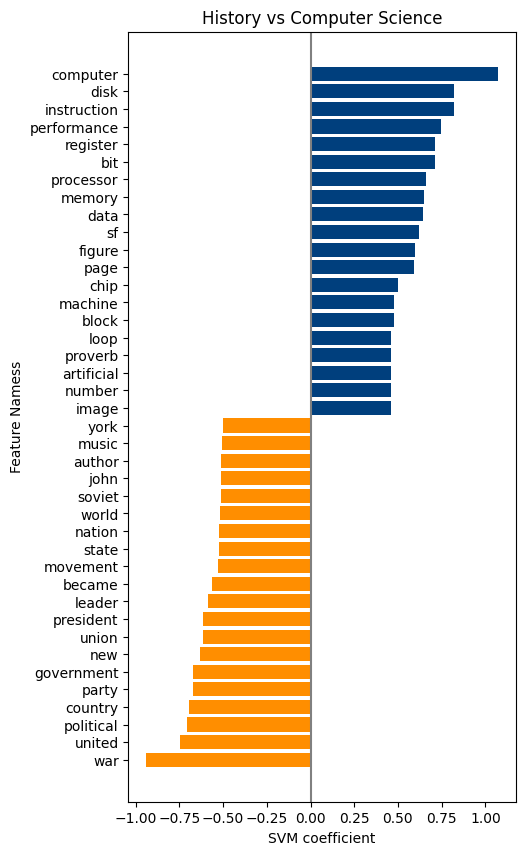

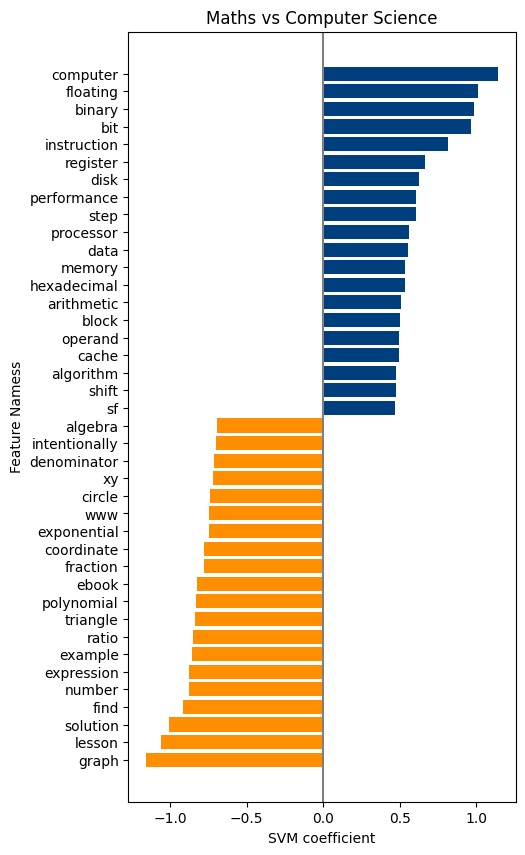

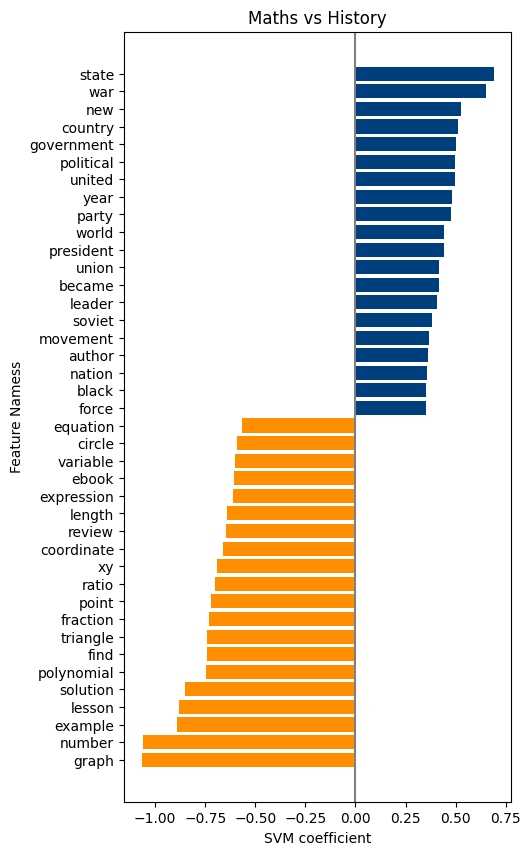

In [478]:
def plot_coefficients(coef:np.ndarray, feature_names:np.ndarray, title:str, top_features=20):
    '''Plots the n top features of set of coefficients in a binary classsifier'''

    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])

    plt.figure(figsize=(5, 10))
    colors = ['#ff8e00' if c < 0 else '#003f7d' for c in coef[top_coefficients]]
    plt.barh(np.arange(2 * top_features), coef[top_coefficients], color=colors)

    plt.yticks(np.arange(0, 2 * top_features), feature_names[top_coefficients])
    plt.title(title)
    plt.ylabel('Feature Names')
    plt.xlabel('SVM coefficient')
    plt.axvline(x=0, color='gray', linestyle='-')
    plt.show()

# SVM computes coefficients for each possible combination of classes using this order according to https://stackoverflow.com/questions/35170805/sklearn-svm-coefficient-attribute-how-to-get-class-name
comparisons = {
 0: 'History vs Computer Science',
 1: 'Maths vs Computer Science',
 2: 'Maths vs History',
}

# Plot each classification
for row in [0,1,2]:
 plot_coefficients(SVM.coef_.getrow(row).toarray()[0], Tfidf_vect.get_feature_names_out(), comparisons[row])